In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from os.path import exists, join as pjoin, realpath
NBROOT = realpath(os.curdir)

import logging
logging.basicConfig(level=logging.DEBUG)
logging.getLogger('PIL').level = logging.INFO # PIL.PngImagePlugin

import sys
sys.path.append(realpath('..'))
sys.path.append(realpath('../../eslope/development/src'))

from glob import glob
import json
from pathlib import Path
from time import time
from urllib.error import HTTPError
from urllib.request import urlopen, urlretrieve
from subprocess import check_call, CalledProcessError

try:
    # like os.system but with live output
    from IPython.utils.process import system
    def check_run(cmd):  # type:ignore
        r = system(cmd)
        if r: raise CalledProcessError(r, cmd)
        return r
except ImportError:
    def check_run(cmd):
        return check_call(cmd, shell=True)

#external
#!pip install shapely
import shapely
from shapely.geometry import mapping, shape, GeometryCollection, Polygon, Point
from shapely.ops import cascaded_union
import numpy as np
from IPython.display import display, Image
from PIL import Image as Img
import mercantile as T
from osgeo import gdal
gdal.UseExceptions()

# own
import mbt_util as M
import bbox
from mbt_util import mbt_merge, mbt_info
from src import etopo_meta as E, img_util as G, geometry as GY, \
    mbt_download as MD, mbt_partial as MP, mbt_pyramid as MY, swisstopo as SS
from src.jpg_quality_pil_magick import get_jpg_quality


In [3]:
%cd /opt/map/mapdata/mbtiles

/home/me/Downloads/dwnmaps/mapdata/mbtiles


In [4]:
names = GY.bbalp_names
paths = {i: name + '.mbtiles' for i, name in names.items()}


INFO:shapely.geos:Self-intersection at or near point 10.54688 47.517200000000003


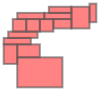

In [15]:
GY.etopo2geojson(NBROOT+'/../data/areas/etopo_alps_extents.geojson')
GY.MultiPolygon(map(GY.bb2poly, GY.bbalps.values()))

In [ ]:
for path in (
    '../mobac_atlases/Kompass_dolo.mbtiles',
    *glob(f'mch*.mbtiles'),
    *glob(f'Bugianen*.mbtiles'),
    *glob('../mobac_atlases/IGNt*.mbtiles'),
    *glob(f'alps*.mbtiles'),
):
    print(M.mbt_info(path)[16:44], os.path.basename(path)[:-8] )

= 71118 * 32 kb/tile q = 89  Kompass_dolo
= 3375 * 34 kb/tile q = 88 ; mch-z9-12
= 64265 * 29 kb/tile q = 88  mch9
= 280691 * 28 kb/tile q = 95 mch
= 61937 * 28 kb/tile q = 95  mch5
= 28259 * 31 kb/tile q = 88  mch7
= 55846 * 30 kb/tile q = 95  mch6
 = 152742 * 23 kb/tile q = 8 Bugianen
 = 61535 * 23 kb/tile q = 80 Bugianen-calps
= 4949 * 18 kb/tile q = 75 ; IGNt11-alps
= 68832 * 19 kb/tile q = 75  IGNt1-Mercantour-Ubaye-Antibes-Embrun
= 49153 * 20 kb/tile q = 75  IGNt4-Chartreuse-Vanoise Chambery-Bardon
= 62043 * 18 kb/tile q = 75  IGNt5-MontBlanc-Chambery-Evian
= 55476 * 20 kb/tile q = 75  IGNt3-Vercors-Ecrins-Cerces
= 65536 * 19 kb/tile q = 75  IGNt2-Digne-Aups-Eguilles-Gap
= 15393 * 20 kb/tile q = 75  IGNt111-addendum
= 109296 * 25 kb/tile q = 75 alps5-Mont-Blanc-Leman-Cervino-Cogne
= 65035 * 24 kb/tile q = 88  alps8
= 68648 * 37 kb/tile q = 95  alps3-Vercors-Ecrins-Queyras-Cozie
= 64814 * 45 kb/tile q = 99  alps4-Grenoble-Savoie-Susa-Lanzo-GParadiso
= 3439 * 35 kb/tile q = 1 ;  al

In [6]:
M.mbt_info('mch.mbtiles')

'zoom = 9 16 ; n = 280691 * 28 kb/tile q = 95 ; bounds = 8.4375,46.55886,10.54688,47.04018 ; center = 4.57031,44.83975,9 ; format = jpeg ; name = SwissTopo mix-scale'

In [6]:
M.get_meta('mch.mbtiles')

{'name': 'SwissTopo mix-scale',
 'description': 'Switzerland SwissTopo National Map, zoom 9-16. https://map.geo.admin.ch\nUnlike the website, this is a downscaled version when possible (1 zoom level up for each layer).',
 'bounds': '4.21875,44.59047,13.35938,48.45835',
 'format': 'jpeg',
 'type': 'baselayer',
 'center': '8.78906,46.52441,9',
 'minzoom': '9',
 'maxzoom': '12'}

## Z12

Make the low-zoom (6-8 + 9-12) file (111 MB)

* OpenTopoMap z6-8 TMS: -11.25 40.99 22.49 48.91
* IGN 9-12:
  * z10: -5.27, 42.29, 8.79, 51.18
  * z12: -5.01, 42.29, 8.61, 51.12
  * Corsica z11 : 8.44 41.25 9.66 43.06
* SwissTopo swisstopo.py: bbch12
* Kompass z9-12 (really just 11-12)

In [51]:
bbox.BBox(8.4, 41.26, 9.6, 43.03).snap_to_xyz(z=11)

BBox(w=8.4375, s=41.244772343082076, e=9.66796875, n=43.06888777416962)

In [9]:
mbtch12 = M.cut_zoom('mch.mbtiles', zooms=[9, 10, 11, 12], overwrite=True)

Overwriting  mch-z9-12.mbtiles
z 9 : 104
z 10 : 416
z 11 : 264
z 12 : 2591


In [21]:
mbtch12 = 'chz12.mbtiles'  # now a dedicated download

In [41]:
M.real_bounds( 'chz12.mbtiles', log=print)

real bounds  11 [5.63, 45.46, 11.25, 48.22] 1056 1315 1087 1337
real bounds  12 [5.45, 45.4, 11.25, 48.17] 2110 2629 2175 2674


(11,
 12,
 LngLatBbox(west=5.449218749999985, south=45.398449976304086, east=11.249999999999998, north=48.22467264956519))

In [56]:
M.mbt_merge('../mobac_atlases/IGNt0-z12-Corsica.mbtiles', dest='../mobac_atlases/IGN-fr-z9-12.mbtiles')

<< ../mobac_atlases/IGNt0-z12-Corsica : zoom = 9 12 ; n = 526 * 11 kb/tile q = 75 ; bounds = 8.438,40.982,9.842,43.069 ; format = jpg ; name = IGN-z12-Corsica
Deduplicated 0 tiles.
>> ../mobac_atlases/IGN-fr-z9-12 : zoom = 9 12 ; n = 27920 q = 75 ; bounds = 0.0,42.03297,9.14063,48.9225 ; center = 4.57031,45.47774,9 ; format = jpg ; name = IGN France baselayer z9-12
Meta update {'bounds': '-5.625,40.9799,9.84375,51.17934',
 'center': '2.10937,46.07962,9',
 'maxzoom': 12,
 'minzoom': 9,
 'type': 'baselayer'}


In [ ]:
M.real_bounds('../mobac_atlases/IGN-fr-z9-12.mbtiles', log=print)

real bounds  9 [-5.63, 42.03, 9.14, 51.18] 248 322 268 340
real bounds  10 [-5.27, 42.29, 8.79, 51.18] 497 645 536 681
real bounds  11 [-5.1, 42.29, 8.61, 51.18] 995 1290 1072 1363
real bounds  12 [-5.01, 42.29, 8.61, 51.12] 1991 2580 2145 2726


(9,
 12,
 LngLatBbox(west=-5.625000000000014, south=42.03297433244139, east=9.140625000000004, north=51.179342979289274))

In [84]:
! rm 'alps-z612.mbtiles'
M.mbt_merge('../mobac_atlases/IGN-fr-z9-12.mbtiles', 'Kompass_dolo.mbtiles', 'chz9z10.mbtiles', 'chz12.mbtiles',
            '../mobac_atlases/OpenTopoMap-z58.mbtiles', dest='alps-z612.mbtiles',
            bb=GY.LLBb(0.0,40.97,22.5,48.92), zmin=6, zmax=12)

cut_to_lnglat ../mobac_atlases/IGN-fr-z9-12.mbtiles -> alps-z612.mbtiles
z6: no tiles, skipping
z7: no tiles, skipping
z8: no tiles, skipping
z 9: +188 tiles: 256<x<269 320<y<335
z 10: +700 tiles: 512<x<539 641<y<671
z 11: +2722 tiles: 1024<x<1078 1282<y<1343
z 12: +10856 tiles: 2048<x<2157 2564<y<2687
Meta update {'bounds': '0.0,40.9799,9.84375,48.9225',
 'center': '4.92188,44.95120,9',
 'maxzoom': 12,
 'minzoom': 9,
 'type': 'baselayer'}
<< Kompass_dolo : zoom = 8 15 ; n = 71118 * 32 kb/tile q = 89 ; bounds = 8.4375,45.08904,12.65625,47.98992 ; center = 10.54688,46.53948,8 ; format = jpg ; name = Kompass_dolo
Deduplicated 11 tiles.
cut_to_lnglat Kompass_dolo.mbtiles -> /tmp/tmp.mbtiles
>> alps-z612 : zoom = 8 12 ; n = 15601 q = 75 ; bounds = -5.625,40.9799,9.84375,51.17934 ; center = 2.10937,46.07962,9 ; format = jpg ; name = IGN France baselayer z9-12
<< chz9z10 : zoom = 9 10 ; n = 520 * 30 kb/tile q = 88 ; bounds = 4.21875,44.59047,13.35938,48.45835 ; center = 8.78906,46.52441,9 ; 

In [57]:
M.real_bounds('alpsz12.mbtiles', log=print)

real bounds  5 [0.0, 40.98, 22.5, 48.92] 16 20 17 20
real bounds  6 [0.0, 40.98, 22.5, 48.92] 32 40 35 41
real bounds  7 [0.0, 40.98, 22.5, 48.92] 64 80 71 83
real bounds  8 [0.0, 40.98, 22.5, 48.92] 128 160 143 167
real bounds  9 [0.0, 42.03, 13.36, 48.92] 256 322 274 335
real bounds  10 [0.0, 42.29, 13.36, 48.92] 512 645 549 671
real bounds  11 [0.0, 42.29, 11.25, 48.92] 1024 1290 1087 1343
real bounds  12 [0.0, 42.29, 11.25, 48.92] 2048 2580 2175 2687


(5,
 12,
 LngLatBbox(west=0.0, south=40.979898069620134, east=22.50000000000001, north=48.92249926375824))

In [58]:
wjpg = G.white_jpg(256)
z, x, y = M.lnglat2tms(16, lng=9, lat=46)
M.insert_tiles('alpsz12.mbtiles', [(z, x, y, wjpg)])
M.set_real_bounds('alpsz12.mbtiles')
M.mbt_info('alpsz12.mbtiles')

'zoom = 5 16 ; n = 16194 * 23 kb/tile q = 1 ; bounds = 0.0,40.9799,22.5,48.9225 ; center = 11.25000,44.95120,5 ; format = jpg ; name = alpsz12'

In [34]:
M.cut_zoom('alpsz12.mbtiles', alpslog=print)

real bounds  5 [0.0, 40.98, 22.5, 48.92] 16 20 17 20
real bounds  6 [0.0, 40.98, 16.87, 48.92] 32 40 34 41
real bounds  7 [2.81, 43.07, 16.87, 48.92] 65 81 69 83
real bounds  8 [4.22, 43.07, 15.47, 47.99] 131 162 138 166
real bounds  10 [5.63, 45.58, 11.25, 48.22] 528 658 543 668
real bounds  11 [5.45, 45.34, 11.25, 48.22] 1055 1314 1087 1337
real bounds  12 [5.45, 45.4, 11.25, 48.17] 2110 2629 2175 2674
real bounds  16 [9.0, 46.0, 9.0, 46.0] 34406 42220 34406 42220


(5,
 16,
 LngLatBbox(west=0.0, south=40.979898069620134, east=22.499999999999996, north=48.92249926375824))

## Z16

In [42]:
for path in glob(f'mch*.mbtiles'):
    print(path[:4],
    tuple(round(n, 2) for n in M.real_bounds(path)[2]),  #bb max (union) of zmax
    tuple(round(n, 2) for n in M.real_bounds(path, strict=True)[2]), # bb min (intersection) of zmax
    tuple(round(n, 2) for n in M.compute_inner_bounds(path)),  # min of zcenter
    tuple(round(n, 2) for n in M.compute_strictest_bounds(path)),  # min of zborders
    #  mbt_info(path),
     sep='\n')

mch8
(6.33, 46.56, 8.44, 47.04)
(6.33, 46.56, 8.44, 47.04)
(6.33, 46.56, 8.44, 47.04)
(6.56, 46.56, 8.44, 47.0)
mch9
(8.44, 46.56, 10.55, 47.04)
(8.44, 46.56, 10.55, 47.04)
(8.44, 46.56, 10.55, 47.04)
(8.44, 46.56, 10.46, 46.95)
mch.
(4.22, 44.59, 13.36, 48.46)
(5.98, 45.8, 10.55, 47.04)
(5.98, 46.25, 10.2, 47.04)
(9.07, 46.54, 9.07, 46.56)
mch5
(5.63, 45.58, 7.73, 46.56)
(5.98, 45.81, 7.73, 46.56)
(5.98, 45.93, 7.73, 46.56)
(7.12, 46.13, 6.79, 46.56)
mch7
(9.14, 45.58, 10.55, 46.56)
(9.14, 45.81, 10.55, 46.56)
(9.14, 46.34, 9.28, 46.56)
(9.14, 46.54, 9.27, 46.56)
mch6
(7.73, 45.58, 9.14, 46.56)
(7.73, 45.8, 9.14, 46.56)
(7.73, 46.14, 9.14, 46.56)
(9.07, 45.93, 9.07, 46.56)


In [9]:
from glob import glob

for path in glob(f'*.mbtiles'):
    print(mbt_info(path), path[:4])

zoom = 9 16 ; n = 64787 * 22 kb/tile ; bounds = 5.625,45.58329,7.03125,46.55886 ; center = 6.32813,46.07108,9 ; format = jpg ; name = frit5-Mont-Blanc-Leman-Cervino-Cogne frit
zoom = 9 16 ; n = 109296 * 25 kb/tile ; bounds = 5.625,45.58329,7.73438,46.55886 ; center = 6.67969,46.07108,9 ; format = jpg ; name = alps5-Mont-Blanc-Leman-Cervino-Cogne alps
zoom = 9 16 ; n = 68648 * 37 kb/tile ; bounds = 4.92188,44.58656,7.73438,45.08904 ; center = 6.32813,44.83780,9 ; format = jpg ; name = alps3-Vercors-Ecrins-Queyras-Cozie alps
zoom = 12 16 ; n = 152742 * 23 kb/tile ; bounds = 6.67969,45.58329,7.73438,46.01222 ; center = 7.20703,45.79776,12 ; format = jpg ; name = Bugianen Bugi
zoom = 9 16 ; n = 64814 * 45 kb/tile ; bounds = 5.625,45.08904,8.4375,45.58329 ; center = 7.03125,45.33616,9 ; format = jpg ; name = alps4-Grenoble-Savoie-Susa-Lanzo-GParadiso alps
zoom = 12 16 ; n = 61535 * 23 kb/tile ; bounds = 6.76758,44.02442,8.17383,44.59047 ; center = 7.47070,44.30744,12 ; format = jpg ; name =

In [15]:
for N in (5,6,7,8,9, 10):
    print(N)
    name, chcpath = names[N], paths[N]
    if not os.path.exists(chcpath):
        continue
        M.cut_to_lnglat('mch.mbtiles', chcpath, GY.bbalps[N])
    M.update_mbt_meta(chcpath, name=name)
    M.set_real_bounds(chcpath)

5
6
7
8
9
10


In [21]:
M.get_meta(paths[9])

{'name': 'alps9-CHCW-Vaud-Luzern-Grimselpass',
 'description': 'Switzerland SwissTopo National Map, zoom 9-16. https://map.geo.admin.ch\nUnlike the website, this is a downscaled version when possible (1 zoom level up for each layer).',
 'bounds': '6.32812,46.55886,8.4375,47.04018',
 'format': 'jpeg',
 'type': 'baselayer',
 'center': '7.38281,46.79952,10',
 'minzoom': '10',
 'maxzoom': '16'}

In [20]:
M.remove_lnglat(f'{paths[9][:-8]}z9.mbtiles', paths[9], zmin=9, zmax=9)

cp alps9-CHCW-Vaud-Luzern-Grimselpassz9.mbtiles alps9-CHCW-Vaud-Luzern-Grimselpass.mbtiles
<<>> alps9-CHCW-Vaud-Luzern-Grimselpassz9 : zoom = 9 16 ; n = 65035 * 24 kb/tile q = 88 ; bounds = 6.32812,46.55886,8.4375,47.04018 ; center = 7.38281,46.79952,9 ; format = jpeg ; name = alps9-CHCW-Vaud-Luzern-Grimselpass
z 9 : removed 3
Meta update {'bounds': '6.32812,46.55886,8.4375,47.04018',
 'center': '7.38281,46.79952,10',
 'maxzoom': 16,
 'minzoom': 10,
 'type': 'baselayer'}


In [47]:
print(M.mbt_info(paths[2]))
M.remove_lnglat(f'{paths[2]}', zmin=9, zmax=9)

zoom = 9 16 ; n = 65536 * 19 kb/tile q = 75 ; bounds = 4.922,43.580,6.328,44.590 ; format = jpg ; name = IGNt2-Digne-Aups-Eguilles-Gap
Backing up source as: alps2-Digne-Aups-Eguilles-Gap.mbtiles
cp alps2-Digne-Aups-Eguilles-Gap.bak.mbtiles alps2-Digne-Aups-Eguilles-Gap.mbtiles
<<>> alps2-Digne-Aups-Eguilles-Gap.bak : zoom = 9 16 ; n = 65536 * 19 kb/tile q = 75 ; bounds = 4.922,43.580,6.328,44.590 ; format = jpg ; name = IGNt2-Digne-Aups-Eguilles-Gap
z 9 : removed 4
Meta update {'bounds': '5.27344,43.58039,6.32813,44.59047',
 'center': '5.80078,44.08543,10',
 'maxzoom': 16,
 'minzoom': 10,
 'type': 'baselayer'}


In [16]:
M.cut_to_lnglat(paths[1], bb=GY.bbalps1z10)

Backing up source as: alps1-Mercantour-Ubaye-Cuneese.mbtiles
10 16 16
z 10: +20 tiles: 530<x<534 650<y<653
z 11: +71 tiles: 1060<x<1068 1300<y<1307
z 12: +292 tiles: 2120<x<2139 2600<y<2615
z 13: +1070 tiles: 4240<x<4279 5200<y<5231
z 14: +4268 tiles: 8480<x<8559 10400<y<10463
z 15: +16982 tiles: 16960<x<17119 20800<y<20927
z 16: +67313 tiles: 33920<x<34239 41600<y<41855
Meta update {'bounds': '6.32812,43.58039,8.08594,44.59047',
 'center': '7.20703,44.08543,10',
 'maxzoom': 16,
 'minzoom': 10,
 'type': 'baselayer'}


In [14]:
M.real_bounds(paths[1], log=print)

real bounds  10 [6.33, 43.58, 8.44, 44.59] 530 650 535 653
real bounds  11 [6.33, 43.58, 7.91, 44.59] 1060 1300 1068 1307
real bounds  12 [6.33, 43.58, 8.17, 44.59] 2120 2600 2140 2615
real bounds  13 [6.33, 43.58, 8.17, 44.59] 4240 5200 4281 5231
real bounds  14 [6.33, 43.58, 8.17, 44.59] 8480 10400 8563 10463
real bounds  15 [6.33, 43.58, 8.17, 44.59] 16960 20800 17127 20927
real bounds  16 [6.33, 43.58, 8.17, 44.59] 33920 41600 34255 41855


(10,
 16,
 LngLatBbox(west=6.328124999999996, south=43.580390855607845, east=8.437500000000014, north=44.590467181308846))

# `alps1` to `alps5`: Merge IGN and Bugianen

This is done in the `merge_frit*.ipynb` notebooks.

# `alps6` and `alps7`: Merge SwissTopo with Bugianen

In [21]:
mbtit7 = 'tmpit7.mbtiles'
M.cut_to_lnglat('Bugianen.mbtiles', bb=GY.bbalps7, dest=mbtit7, overwrite=True)


Overwriting  tmpit7.mbtiles
12 16 16
z 12: +120 tiles: 2136<x<2147 2632<y<2646
z 13: +480 tiles: 4272<x<4295 5264<y<5293
z 14: +1920 tiles: 8544<x<8591 10528<y<10587
z 15: +7680 tiles: 17088<x<17183 21056<y<21175
z 16: +30720 tiles: 34176<x<34367 42112<y<42351
Meta update {'bounds': '7.73437,45.58329,8.78906,46.49839',
 'center': '8.26172,46.04084,12',
 'maxzoom': 16,
 'minzoom': 12,
 'type': 'baselayer'}


In [23]:
mbtch7 = paths[7].replace('alps', 'mch')
M.remove_lnglat(mbtch7, zmin=9, zmax=9)

Backing up source as: mch7-Ticino-Jungfrau-Lorenzhorn-MtRosa.mbtiles
cp mch7-Ticino-Jungfrau-Lorenzhorn-MtRosa.bak.mbtiles mch7-Ticino-Jungfrau-Lorenzhorn-MtRosa.mbtiles
<<>> mch7-Ticino-Jungfrau-Lorenzhorn-MtRosa.bak : zoom = 9 16 ; n = 55846 * 30 kb/tile q = 95 ; bounds = 5.625,45.58329,7.73438,46.55886 ; center = 6.67969,46.07108,9 ; format = jpeg ; name = SwissTopo mix#6
z 9 : removed 4
Meta update {'bounds': '7.73437,45.58329,9.14063,46.55886',
 'center': '8.43750,46.07108,10',
 'maxzoom': 16,
 'minzoom': 10,
 'type': 'baselayer'}


In [24]:
mbtch7 = paths[7].replace('alps', 'mch')
M.mbt_merge(mbtit7, mbtch7, dest=paths[7], name=names[7])

cp tmpit7.mbtiles alps7-Ticino-Jungfrau-Lorenzhorn-MtRosa.mbtiles
<<>> tmpit7 : zoom = 12 16 ; n = 40920 * 22 kb/tile q = 80 ; bounds = 6.67969,45.58329,7.73438,46.01222 ; center = 7.20703,45.79776,12 ; format = jpg ; name = Bugianen
<< mch7-Ticino-Jungfrau-Lorenzhorn-MtRosa : zoom = 10 16 ; n = 55842 * 30 kb/tile q = 95 ; bounds = 7.73437,45.58329,9.14063,46.55886 ; center = 8.43750,46.07108,10 ; format = jpeg ; name = SwissTopo mix#6
>> alps7-Ticino-Jungfrau-Lorenzhorn-MtRosa : zoom = 10 16 ; n = 77519 q = 80 ; bounds = 6.67969,45.58329,7.73438,46.01222 ; center = 7.20703,45.79776,12 ; format = jpg ; name = Bugianen
Meta update {'bounds': '7.73437,45.58329,9.14063,46.55886',
 'center': '8.43750,46.07108,10',
 'maxzoom': 16,
 'minzoom': 10,
 'type': 'baselayer'}
Created: alps7-Ticino-Jungfrau-Lorenzhorn-MtRosa


Since the merged file is over 2Gb, I've changed slightly the `bbalps[6]` and `7` definition,
moving the limit from *lng77z9_sanremo_zermatt* to *lng80z10_imperia_biella*


In [31]:
bb7to6 = M.LLBb(GY.lng77z9_sanremo_zermatt, GY.lat55z9_chambery_biella_trieste, GY.lng80z10_imperia_biella, GY.lat65z9_lausanne_smoritz_bolzano)
M.cut_to_lnglat(paths[7], bb=bb7to6, dest='tmp7to6small.mbtiles')

10 16 16
z 10: +8 tiles: 534<x<535 658<y<661
z 11: +28 tiles: 1068<x<1071 1317<y<1323
z 12: +128 tiles: 2136<x<2143 2632<y<2647
z 13: +504 tiles: 4272<x<4287 5264<y<5295
z 14: +2016 tiles: 8544<x<8575 10528<y<10591
z 15: +8064 tiles: 17088<x<17151 21056<y<21183
z 16: +32256 tiles: 34176<x<34303 42112<y<42367
Meta update {'bounds': '7.73437,45.58329,8.4375,46.55886',
 'center': '8.08594,46.07108,10',
 'maxzoom': 16,
 'minzoom': 10,
 'type': 'baselayer'}
10 16 16
z 10: +4 tiles: 534<x<534 658<y<661
z 11: +14 tiles: 1068<x<1069 1317<y<1323
z 12: +64 tiles: 2136<x<2139 2632<y<2647
z 13: +256 tiles: 4272<x<4279 5264<y<5295
z 14: +1024 tiles: 8544<x<8559 10528<y<10591
z 15: +4096 tiles: 17088<x<17119 21056<y<21183
z 16: +16384 tiles: 34176<x<34239 42112<y<42367
Meta update {'bounds': '7.73437,45.58329,8.08594,46.55886',
 'center': '7.91016,46.07108,10',
 'maxzoom': 16,
 'minzoom': 10,
 'type': 'baselayer'}


In [24]:
M.real_bounds('tmp7to6small.mbtiles', log=print)

real bounds  10 [7.73, 45.58, 8.09, 46.56] 534 658 534 661
real bounds  11 [7.73, 45.71, 8.09, 46.56] 1068 1317 1069 1323
real bounds  12 [7.73, 45.58, 8.09, 46.56] 2136 2632 2139 2647
real bounds  13 [7.73, 45.58, 8.09, 46.56] 4272 5264 4279 5295
real bounds  14 [7.73, 45.58, 8.09, 46.56] 8544 10528 8559 10591
real bounds  15 [7.73, 45.58, 8.09, 46.56] 17088 21056 17119 21183
real bounds  16 [7.73, 45.58, 8.09, 46.56] 34176 42112 34239 42367


(10,
 16,
 LngLatBbox(west=7.734374999999989, south=45.58328975600631, east=8.085937500000016, north=46.55886030311717))

In [8]:
M.real_bounds('alps6-Aoste-Martigny-Gruyère.mbtiles', log=print)

real bounds  10 [7.03, 45.58, 7.73, 46.56] 532 658 533 661
real bounds  11 [7.03, 45.58, 7.73, 46.56] 1064 1316 1067 1323
real bounds  12 [7.03, 45.58, 7.73, 46.56] 2128 2632 2135 2647
real bounds  13 [7.03, 45.58, 7.73, 46.56] 4256 5264 4271 5295
real bounds  14 [7.03, 45.58, 7.73, 46.56] 8512 10528 8543 10591
real bounds  15 [7.03, 45.58, 7.73, 46.56] 17024 21056 17087 21183
real bounds  16 [7.03, 45.58, 7.73, 46.56] 34048 42112 34175 42367


(10,
 16,
 LngLatBbox(west=7.03125000000001, south=45.58328975600631, east=7.734375000000008, north=46.55886030311717))

In [13]:
M.mbt_merge('alps6-Aoste-Martigny-Gruyère.mbtiles', 'tmp7to6small.mbtiles', dest=paths[6], name=names[6])

cp alps6-Aoste-Martigny-Gruyère.mbtiles alps6-Aoste-Martigny-Monch-MtRosa.mbtiles
<<>> alps6-Aoste-Martigny-Gruyère : zoom = 10 16 ; n = 43687 * 30 kb/tile q = 80 ; bounds = 7.03125,45.58329,7.73438,46.55886 ; center = 7.38281,46.07108,10 ; format = jpg ; name = alps6-Aoste-Martigny-Gruyère
<< tmp7to6small : zoom = 10 16 ; n = 21842 * 30 kb/tile q = 80 ; bounds = 7.73437,45.58329,8.4375,46.55886 ; center = 8.08594,46.07108,10 ; format = jpg ; name = alps7-Ticino-Jungfrau-Lorenzhorn-MtRosa
>> alps6-Aoste-Martigny-Monch-MtRosa : zoom = 10 16 ; n = 65529 q = 80 ; bounds = 7.03125,45.58329,7.73438,46.55886 ; center = 7.38281,46.07108,10 ; format = jpg ; name = alps6-Aoste-Martigny-Gruyère
Meta update {'bounds': '7.03125,45.58329,8.08594,46.55886',
 'center': '7.55859,46.07108,10',
 'maxzoom': 16,
 'minzoom': 10,
 'type': 'baselayer'}
Created: alps6-Aoste-Martigny-Monch-MtRosa


In [17]:
M.update_mbt_meta(paths[6], desc=
    M.get_meta('alps6-Aoste-Martigny-Gruyère.mbtiles')['description'])

In [18]:
M.get_meta(paths[6])

{'bounds': '7.03125,45.58329,8.08594,46.55886',
 'name': 'alps6-Aoste-Martigny-Monch-MtRosa',
 'type': 'baselayer',
 'version': '1.1',
 'description': 'Merge of the following files:\n* Bugianen : Bugianen 2205 Cervino : Mappa escursionistica delle alpi piemontesi, valdostane e dintorni.\nLicenza Creative Commons CC BY-NC-SA 3.0 IT.\nPer la legenda e l\'origine dei dati visita <a href="https://tartamillo.wordpress.com/sorbetto/">tartamillo.wordpress.com/sorbetto/</a>\n* frit5-Mont-Blanc-Leman-Cervino-Cogne : IGNt5-MontBlanc-Chambery-Evian created on 2021-02-20 01:52:46 by MOBAC\n* IGN France baselayer z9-12 : IGN France baselayer z9-12\n* SwissTopo mix-scale : Switzerland SwissTopo National Map, zoom 9-16. https://map.geo.admin.ch\nUnlike the website, this is a downscaled version when possible (1 zoom level up for each layer).\n',
 'format': 'jpg',
 'attribution': '<a href="https://tartamillo.wordpress.com/sorbetto/">© tartamillo.wordpress.com</a>. Source data: OpenStreetMap contributor

In [25]:
M.remove_lnglat('alps7-Ticino-Jungfrau-Lorenzhorn-MtRosa.mbtiles', paths[7], bb=bb7to6)

cp alps7-Ticino-Jungfrau-Lorenzhorn-MtRosa.mbtiles alps7-Ticino-Finsteraarhorn-Lorenzhorn.mbtiles
<<>> alps7-Ticino-Jungfrau-Lorenzhorn-MtRosa : zoom = 10 16 ; n = 77519 * 29 kb/tile q = 80 ; bounds = 7.73437,45.58329,8.08594,46.55886 ; center = 7.91016,46.07108,10 ; format = jpg ; name = alps7-Ticino-Jungfrau-Lorenzhorn-MtRosa
10 16 16
z 10 : removed 4
z 11 : removed 14
z 12 : removed 64
z 13 : removed 256
z 14 : removed 1024
z 15 : removed 4096
z 16 : removed 16384
Meta update {'bounds': '8.08594,45.58329,9.14063,46.55886',
 'center': '8.61328,46.07108,10',
 'maxzoom': 16,
 'minzoom': 10,
 'type': 'baselayer'}


In [27]:
M.real_bounds(paths[7], log=print)

real bounds  10 [8.09, 45.58, 9.14, 46.56] 535 658 537 661
real bounds  11 [8.09, 45.71, 9.14, 46.56] 1070 1317 1075 1323
real bounds  12 [8.09, 45.58, 9.14, 46.56] 2140 2632 2151 2647
real bounds  13 [8.09, 45.58, 9.14, 46.56] 4280 5264 4303 5295
real bounds  14 [8.09, 45.58, 9.14, 46.56] 8560 10528 8607 10591
real bounds  15 [8.09, 45.58, 9.14, 46.56] 17120 21056 17215 21183
real bounds  16 [8.09, 45.58, 9.14, 46.56] 34240 42112 34431 42367


(10,
 16,
 LngLatBbox(west=8.085937500000014, south=45.58328975600631, east=9.140625000000002, north=46.55886030311717))

# Kompass

In [ ]:
M.real_bounds('../mobac_atlases/Kompass_dolo.mbtiles', log=print)

real bounds  8 [8.44, 45.09, 12.66, 47.99] 134 164 136 166
real bounds  9 [9.14, 45.58, 12.66, 47.99] 269 329 273 333
real bounds  10 [9.14, 45.83, 12.66, 47.75] 538 659 547 666
real bounds  11 [9.14, 45.83, 12.48, 47.75] 1076 1318 1094 1333
real bounds  12 [9.14, 45.83, 12.48, 47.75] 2152 2636 2189 2667
real bounds  13 [9.14, 45.83, 12.48, 47.75] 4304 5272 4379 5335
real bounds  14 [9.14, 45.83, 12.48, 47.75] 8608 10544 8759 10671
real bounds  15 [9.14, 45.83, 12.48, 47.75] 17216 21088 17519 21343


(8,
 15,
 LngLatBbox(west=8.437500000000005, south=45.08903556483102, east=12.656250000000009, north=47.98992166741418))

In [ ]:
M.compute_inner_bounds('../mobac_atlases/Kompass_dolo.mbtiles')

LngLatBbox(west=Decimal('8.438'), south=Decimal('45.093'), east=Decimal('12.655'), north=Decimal('47.990')) LngLat(lng=10.5465, lat=46.5415) 8 135 8


LngLatBbox(west=10.37109, south=45.8288, east=12.48047, north=47.5172)

In [ ]:
M.compute_strictest_bounds('../mobac_atlases/Kompass_dolo.mbtiles')

LngLatBbox(west=11.95313, south=46.43029, east=11.95312, north=46.67959)

# `alps8` and `alps10` (and `alps11` soon): Merge SwissTopo and Kompass

In [92]:
!rm alps8-Como-Mesolcina-Adamello-Ortler.mbtiles
M.mbt_merge('Kompass_dolo.mbtiles', 'mch.mbtiles',
            dest=paths[8], bb=GY.bbalps[8], name=E.bbalp_names[8], zmin=10, log=print)

rm: cannot remove 'alps8-Como-Mesolcina-Adamello-Ortler.mbtiles': No such file or directory
cut_to_lnglat Kompass_dolo.mbtiles -> alps8-Como-Mesolcina-Adamello-Ortler.mbtiles
10 15 15
z 10: +12 tiles: 538<x<541 659<y<661
z 11: +48 tiles: 1076<x<1083 1318<y<1323
z 12: +192 tiles: 2152<x<2167 2636<y<2647
z 13: +768 tiles: 4304<x<4335 5272<y<5295
z 14: +3072 tiles: 8608<x<8671 10544<y<10591
z 15: +12288 tiles: 17216<x<17343 21088<y<21183
Fallback `center` to first tile:  8 134 164 9.140625000000004 45.58113309511968
Meta update {'bounds': '9.14062,45.8288,10.54688,46.55886',
 'center': '9.14063,45.58113,8',
 'maxzoom': 15,
 'minzoom': 10,
 'type': 'baselayer'}
<< mch : zoom = 9 16 ; n = 280691 * 28 kb/tile q = 95 ; bounds = 9.14062,45.58329,10.54688,46.55886 ; center = 4.57031,44.83975,9 ; format = jpeg ; name = SwissTopo mix-scale
Overwriting  /tmp/tmp.mbtiles
cut_to_lnglat mch.mbtiles -> /tmp/tmp.mbtiles
10 16 16
z 10: +16 tiles: 538<x<541 658<y<661
z 11: +38 tiles: 1076<x<1083 1317<y<1

In [ ]:
M.update_with(source='chz12.mbtiles', dest=paths[8])

Updated 306


In [93]:
# !rm alps10
M.mbt_merge('Kompass_dolo.mbtiles', 'mch.mbtiles',
            dest=paths[10], bb=GY.bbalps[10], name=E.bbalp_names[10], zmin=10, log=print)

<< Kompass_dolo : zoom = 8 15 ; n = 71118 * 32 kb/tile q = 89 ; bounds = 9.14062,45.8288,10.54688,46.55886 ; center = 9.14063,45.58113,8 ; format = jpg ; name = Kompass_dolo
cut_to_lnglat Kompass_dolo.mbtiles -> /tmp/tmp.mbtiles
10 15 15
z 10: +5 tiles: 538<x<541 662<y<663
z 11: +11 tiles: 1076<x<1083 1324<y<1327
z 12: +44 tiles: 2152<x<2167 2648<y<2655
z 13: +176 tiles: 4304<x<4335 5296<y<5311
z 14: +704 tiles: 8608<x<8671 10592<y<10623
z 15: +2816 tiles: 17216<x<17343 21184<y<21247
Fallback `center` to first tile:  8 134 164 9.140625000000004 45.58113309511968
Meta update {'bounds': '9.14062,46.55886,10.54688,47.04018',
 'center': '9.14063,45.58113,8',
 'maxzoom': 15,
 'minzoom': 10,
 'type': 'baselayer'}
>> alps10-CHCE-Realp-Pfunds : zoom = 9 16 ; n = 64373 q = 88 ; bounds = 8.4375,46.55886,10.54688,47.04018 ; center = 9.49219,46.79952,9 ; format = jpeg ; name = alps10-CHCE-Realp-Pfunds
<< mch : zoom = 9 16 ; n = 280691 * 28 kb/tile q = 95 ; bounds = 9.14062,45.58329,10.54688,46.558

# `alps10` - just zoom



In [99]:
M.remove_lnglat(paths[10], zmin=9, zmax=9)

Backing up source as: ../../mapdata/mbtiles/alps10-CHCE-Realp-Pfunds.mbtiles
cp ../../mapdata/mbtiles/alps10-CHCE-Realp-Pfunds.bak.mbtiles ../../mapdata/mbtiles/alps10-CHCE-Realp-Pfunds.mbtiles
<<>> ../../mapdata/mbtiles/alps10-CHCE-Realp-Pfunds.bak : zoom = 9 16 ; n = 64373 * 29 kb/tile q = 88 ; bounds = 8.4375,46.55886,10.54688,47.04018 ; center = 9.49219,46.79952,9 ; format = jpeg ; name = alps10-CHCE-Realp-Pfunds
z 9 : removed 3
Meta update {'bounds': '8.4375,46.55886,10.54688,47.04018',
 'center': '9.49219,46.79952,10',
 'maxzoom': 16,
 'minzoom': 10,
 'type': 'baselayer'}


# `alps11` - Kompass + SwissTopo


In [10]:
N=11
M.cut_to_lnglat('Kompass_dolo.mbtiles', bb=GY.bbalps[N], dest='tmpKompass11.mbtiles', zmin=10)
# M.update_mbt_meta(paths[12], name=E.bbalp_names[12], desc=E.DESC[12], attrib=E.ATTRIB[12],)

Backing up source as: tmpKompass11.mbtiles
cut_to_lnglat Kompass_dolo.mbtiles -> tmpKompass11.mbtiles
10 15 15
z 10: +2 tiles: 538<x<541 664<y<665
z 11: +4 tiles: 1076<x<1083 1328<y<1331
z 12: +16 tiles: 2152<x<2167 2656<y<2663
z 13: +64 tiles: 4304<x<4335 5312<y<5327
z 14: +256 tiles: 8608<x<8671 10624<y<10655
z 15: +1024 tiles: 17216<x<17343 21248<y<21311
Fallback `center` to first tile:  8 134 164 9.140625000000004 45.58113309511968
Meta update {'bounds': '10.19531,47.04018,10.54688,47.5172',
 'center': '9.14063,45.58113,8',
 'maxzoom': 15,
 'minzoom': 10,
 'type': 'baselayer'}


In [11]:
GY.bbalps[N],\
M.real_bounds('tmpKompass11.mbtiles', log=print),\
M.real_bounds('ch11.mbtiles', log=print)

real bounds  10 [10.2, 47.04, 10.55, 47.52] 541 664 541 665
real bounds  11 [10.37, 47.04, 10.55, 47.52] 1083 1328 1083 1331
real bounds  12 [10.37, 47.04, 10.55, 47.52] 2166 2656 2167 2663
real bounds  13 [10.37, 47.04, 10.55, 47.52] 4332 5312 4335 5327
real bounds  14 [10.37, 47.04, 10.55, 47.52] 8664 10624 8671 10655
real bounds  15 [10.37, 47.04, 10.55, 47.52] 17328 21248 17343 21311
real bounds  10 [8.44, 47.04, 9.84, 47.52] 536 664 539 665
real bounds  11 [8.61, 47.04, 9.84, 47.52] 1073 1328 1079 1331
real bounds  13 [8.75, 47.04, 9.8, 47.52] 4295 5312 4318 5327
real bounds  14 [8.77, 47.04, 9.78, 47.52] 8591 10624 8636 10655
real bounds  15 [8.78, 47.04, 9.78, 47.52] 17183 21248 17273 21311


(LngLatBbox(west=8.789, south=47.04018, east=10.54688, north=47.5172),
 (10,
  15,
  LngLatBbox(west=10.19531249999999, south=47.04018214480665, east=10.546875000000016, north=47.51720069783939)),
 (10,
  15,
  LngLatBbox(west=8.437500000000005, south=47.04018214480665, east=9.843750000000009, north=47.51720069783939)))

In [12]:
M.cut_to_lnglat('chz12.mbtiles', bb=GY.bbalps[N], dest='tmp.mbtiles')


cut_to_lnglat chz12.mbtiles -> tmp.mbtiles
10 12 12
z 10: +12 tiles: 536<x<541 664<y<665
z 11: +44 tiles: 1073<x<1083 1328<y<1331
z 12: +168 tiles: 2147<x<2167 2656<y<2663
Meta update {'bounds': '8.4375,47.04018,10.54688,47.5172',
 'center': '9.49219,47.27869,10',
 'maxzoom': 12,
 'minzoom': 10,
 'type': 'baselayer'}


In [13]:
M.mbt_merge('tmpKompass11.mbtiles',  'tmp.mbtiles', 'ch11.mbtiles', dest=paths[N])

cp tmpKompass11.mbtiles alps11-CHNE-Zurich-LH-Lechtal.mbtiles
<<>> tmpKompass11 : zoom = 10 15 ; n = 1366 * 35 kb/tile q = 89 ; bounds = 10.19531,47.04018,10.54688,47.5172 ; center = 9.14063,45.58113,8 ; format = jpg ; name = Kompass_dolo
<< tmp : zoom = 10 12 ; n = 224 * 37 kb/tile q = 88 ; bounds = 8.4375,47.04018,9.84375,47.5172 ; center = 9.14063,47.27869,10 ; format = jpeg ; name = chz12
>> alps11-CHNE-Zurich-LH-Lechtal : zoom = 10 15 ; n = 1568 q = 89 ; bounds = 10.19531,47.04018,10.54688,47.5172 ; center = 9.14063,45.58113,8 ; format = jpg ; name = Kompass_dolo
<< ch11 : zoom = 10 15 ; n = 7716 * 33 kb/tile q = 88 ; bounds = 8.4375,47.04018,9.84375,47.5172 ; center = 9.14063,47.27869,10 ; format = jpeg ; name = ch11
>> alps11-CHNE-Zurich-LH-Lechtal : zoom = 10 15 ; n = 9248 q = 88 ; bounds = 10.19531,47.04018,10.54688,47.5172 ; center = 9.14063,45.58113,8 ; format = jpg ; name = Kompass_dolo
Meta update {'bounds': '8.4375,47.04018,10.54688,47.5172',
 'center': '9.49219,47.27869,

# `alps12` - Kompass cut

*Waiting for the Swisstopo low-zoom update (etopo#2)
before merging with Kompass since impact is tiny anyway.*

In [94]:
M.cut_to_lnglat('Kompass_dolo.mbtiles', bb=GY.bbalps[12], dest=paths[12], zmin=10)
# M.update_mbt_meta(paths[12], name=E.bbalp_names[12], desc=E.DESC[12], attrib=E.ATTRIB[12],)

cut_to_lnglat Kompass_dolo.mbtiles -> alps12-Arco-Innsbruck-Bruneck-Marmolada.mbtiles
10 15 15
z 10: +28 tiles: 542<x<545 659<y<665
z 11: +112 tiles: 1084<x<1091 1318<y<1331
z 12: +448 tiles: 2168<x<2183 2636<y<2663
z 13: +1792 tiles: 4336<x<4367 5272<y<5327
z 14: +7168 tiles: 8672<x<8735 10544<y<10655
z 15: +28672 tiles: 17344<x<17471 21088<y<21311
Fallback `center` to first tile:  8 134 164 9.140625000000004 45.58113309511968
Meta update {'bounds': '10.54688,45.8288,11.95313,47.5172',
 'center': '9.14063,45.58113,8',
 'maxzoom': 15,
 'minzoom': 10,
 'type': 'baselayer'}


AttributeError: module 'mbt_util' has no attribute 'update_meta'

In [ ]:
# root='/opt/map/mapdata/mbtiles/'
# M.mbt_merge(root+'../mobac_atlases/IGN-walps-z9-10.mbtiles', root+'mchz12.mbtiles',
#             dest=root+'pyrealpsz12.mbtiles',
#             name='pyrenées-alps low zoom (IGN-z10+SwissTopo-z12)')

# Temp - `alps0&2`

In [71]:
M.cut_to_lnglat('../mobac_atlases/IGNt0-Aix-Toulon-Antibes.mbtiles', bb= GY.bbalps0, dest='alps0-1.mbtiles',)
    #bb= GY.LLBb(GY.lng63z9_digne_thones_pontarlier, lat35z9_antibes, lng80z10_imperia_biella, lat45z9_gap)

cut_to_lnglat ../mobac_atlases/IGNt0-Aix-Toulon-Antibes.mbtiles -> alps0-1.mbtiles
10 16 16
z 10: +5 tiles: 530<x<532 648<y<649
z 11: +15 tiles: 1060<x<1064 1296<y<1299
z 12: +53 tiles: 2120<x<2129 2592<y<2599
z 13: +202 tiles: 4240<x<4258 5184<y<5199
z 14: +782 tiles: 8480<x<8517 10368<y<10399
z 15: +3049 tiles: 16960<x<17035 20736<y<20799
z 16: +12118 tiles: 33920<x<34071 41472<y<41599
Meta update {'bounds': '6.32812,43.06889,7.38281,43.58039',
 'center': '6.85547,43.32464,10',
 'maxzoom': 16,
 'minzoom': 10,
 'type': 'baselayer'}


In [65]:
M.cut_to_lnglat('../mobac_atlases/IGNt0-Aix-Toulon-Antibes.mbtiles', bb= GY.bbalps2, dest='alps2-0-tmp.mbtiles',)


cut_to_lnglat ../mobac_atlases/IGNt0-Aix-Toulon-Antibes.mbtiles -> alps2-0-tmp.mbtiles
10 16 16
z 10: +6 tiles: 527<x<529 648<y<649
z 11: +24 tiles: 1054<x<1059 1296<y<1299
z 12: +96 tiles: 2108<x<2119 2592<y<2599
z 13: +384 tiles: 4216<x<4239 5184<y<5199
z 14: +1536 tiles: 8432<x<8479 10368<y<10399
z 15: +6144 tiles: 16864<x<16959 20736<y<20799
z 16: +23808 tiles: 33728<x<33919 41472<y<41599
Meta update {'bounds': '5.27344,43.06889,6.32813,43.58039',
 'center': '5.80078,43.32464,10',
 'maxzoom': 16,
 'minzoom': 10,
 'type': 'baselayer'}


In [66]:
M.mbt_merge('alps2-0-tmp.mbtiles', dest='alps2-Digne-Aups-Eguilles-Gap.mbtiles')

Deduplicated 0 tiles.
<< alps2-0-tmp : zoom = 10 16 ; n = 31998 * 18 kb/tile q = 75 ; bounds = 5.27344,43.06889,7.38281,43.58039 ; center = 6.32812,43.32464,10 ; format = jpg ; name = IGNt0-Aix-Hyeres-AntibesToulon
>> alps2-Digne-Aups-Eguilles-Gap : zoom = 10 16 ; n = 97530 q = 75 ; bounds = 5.27344,43.58039,6.32813,44.59047 ; center = 5.80078,44.08543,10 ; format = jpg ; name = IGNt2-Digne-Aups-Eguilles-Gap
Meta update {'bounds': '5.27344,43.06889,6.32813,44.59047',
 'center': '5.80078,43.82968,10',
 'maxzoom': 16,
 'minzoom': 10,
 'type': 'baselayer'}


b'\xff\xd8\xff\xe0\x00\x10JFIF'


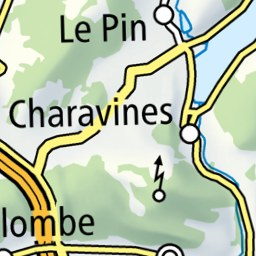

In [44]:
from IPython.display import Image as DImage
z, x, y, img = next(M.get_all_tiles('swissz12_2023.mbtiles', q='WHERE zoom_level=12'))
print(img[:10])
display(DImage(img))

b'\xff\xd8\xff\xe0\x00\x10JFIF'


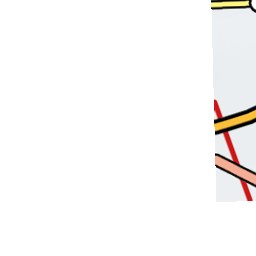

In [41]:
from IPython.display import Image as DImage
tiles = M.get_all_tiles('../mobac_atlases/swissz12_2023.mbtiles', q='WHERE zoom_level=12')
z, x, y, img = next(tiles)
print(img[:10])
display(DImage(img))

In [11]:
M.mbt_merge(
    '../mobac_atlases/IGNt0-Corsica-z16.mbtiles',
    '../mobac_atlases/IGNt0-z12-Corsica.mbtiles',
    'IGNt0-Cannes-Mimosas-Flayosc.mbtiles',
    dest=GY.bbalp_names[0] + '.mbtiles',
    zmin=10)

cp ../mobac_atlases/IGNt0-Corsica-z16.mbtiles alps0-Corse-Maures-Esterel.mbtiles
<<>> ../mobac_atlases/IGNt0-Corsica-z16 : zoom = 13 16 ; n = 72240 * 17 kb/tile q = 75 ; bounds = 8.438,41.245,9.668,43.069 ; format = jpg ; name = IGNt0-Corsica-z16
Deduplicated 2656 tiles.
<< ../mobac_atlases/IGNt0-z12-Corsica : zoom = 9 12 ; n = 526 * 11 kb/tile q = 75 ; bounds = 8.438,40.982,9.842,43.069 ; format = jpg ; name = IGN-z12-Corsica
>> alps0-Corse-Maures-Esterel : zoom = 10 16 ; n = 70102 q = 75 ; bounds = 8.438,41.245,9.668,43.069 ; format = jpg ; name = IGNt0-Corsica-z16
<< IGNt0-Cannes-Mimosas-Flayosc : zoom = 10 16 ; n = 16224 * 16 kb/tile q = 75 ; bounds = 5.27344,43.06889,6.32813,43.58039 ; center = 5.80078,43.32464,10 ; format = jpg ; name = IGNt0-Aix-Hyeres-AntibesToulon
>> alps0-Corse-Maures-Esterel : zoom = 10 16 ; n = 86326 q = 75 ; bounds = 8.438,41.245,9.668,43.069 ; format = jpg ; name = IGNt0-Corsica-z16
Fallback `center` to first tile:  10 530 648 6.503906249999995 43.1970327